# Movie Visualization, Recommendation, Prediction

In [1]:
# import packages
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud as wc
import scipy.sparse as sparse
import xgboost as xgb
import sklearn

from xgboost import XGBRegressor
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold,train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
saving=False

In [2]:
# load data

# 4803 movies
tmdb_5000_movies=pd.read_csv("../input/tmdb-movie-metadata/tmdb_5000_movies.csv",index_col="id")
tmdb_5000_credits=pd.read_csv("../input/tmdb-movie-metadata/tmdb_5000_credits.csv",index_col="movie_id")
tmdb_5000=pd.merge(tmdb_5000_movies,tmdb_5000_credits,left_index=True,right_index=True)
tmdb_5000.dropna(subset=["release_date"],inplace=True)
tmdb_5000.replace(0,np.nan,inplace=True)

# 27278 movies, 138493 users, 20000263 ratings
movielens_rating=pd.read_csv("../input/movielens-20m-dataset/rating.csv")
movielens_link=pd.read_csv("../input/movielens-20m-dataset/link.csv")
movielens_movie=pd.read_csv("../input/movielens-20m-dataset/movie.csv")
movielens_score=pd.read_csv("../input/movielens-20m-dataset/genome_scores.csv")
movielens_tag=pd.read_csv("../input/movielens-20m-dataset/genome_tags.csv")
movielens_dict={v:k for k,v in movielens_link.movieId.to_dict().items()}
movielens_rating.movieId=movielens_rating.movieId.apply(movielens_dict.get)
movielens_rating.userId-=1
movielens_score.movieId=movielens_score.movieId.apply(movielens_dict.get)
movielens_score.tagId-=1
movielens_tag.tagId-=1

## Visualization

In [3]:
# helper functions to deal with multi-hot features
def group_indices(series,index="id"):
    d={}
    for i in range(series.size):
        l=eval(series.iloc[i])
        for x in l:
            d.setdefault(x[index],[])
            d[x[index]].append(i)
    return d

def get_groups(series,index="name"):
    s=set()
    for i in range(series.size):
        l=eval(series.iloc[i])
        for x in l:s.add(x[index])
    return list(s)

def multi_count(series,index="id"):
    return {k:len(v) for (k,v) in group_indices(series,index).items()}

def expand_multi_feature(df,column,index="id"):
    groups=group_indices(df[column],index=index)
    result=pd.DataFrame()
    for name,indices in groups.items():
        rows=df.iloc[indices].copy()
        rows[column]=name
        result=result.append(rows)
    return result

def multi_groupby(df,column,index="id"):
    return expand_multi_feature(df,column,index).groupby(column)

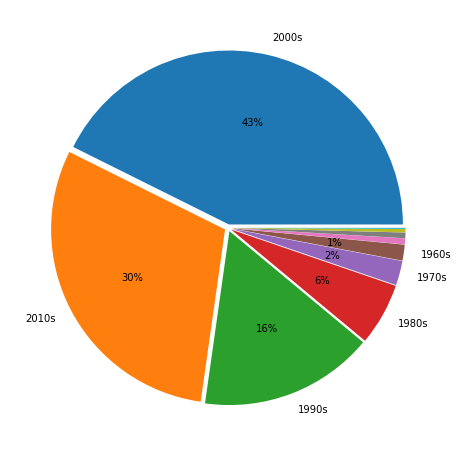

In [4]:
# numbers of movies released in each decade
def count_pie(series,filename):
    counts=series.value_counts()
    counts=counts/counts.sum()
    labels=['' if num<0.01 else str(year) for (year,num) in counts.items()]
    f, ax = plt.subplots(figsize=(8, 8))
    explode = [0.02 if counts.iloc[i] < 100 else 0.001 for i in range(counts.size)]
    plt.pie(counts,labels=labels,autopct=lambda x:'{:1.0f}%'.format(x) if x > 1 else '',explode=explode)
    if saving:plt.savefig(filename,dpi=150)
    plt.show()

def count_decade_pie(df,filename):
    count_pie(df.release_date.dropna().apply(lambda x:str(int(x[:4])//10*10)+'s'),filename)
    
count_decade_pie(tmdb_5000,filename="pie_decade.png")

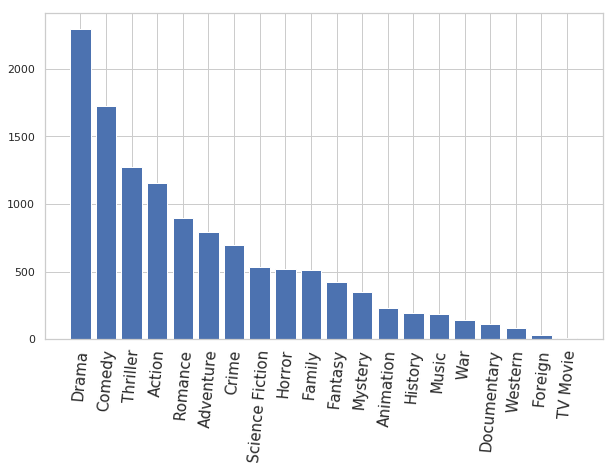

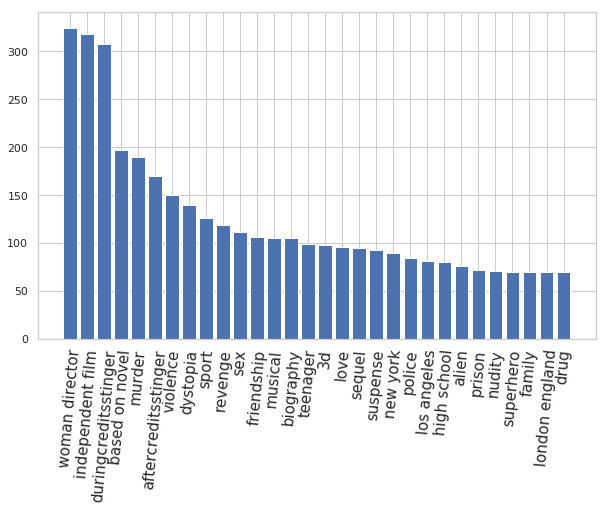

In [5]:
# numbers of movies of different genres and keywords
def multi_bar(series,filename):    
    sns.set(style="whitegrid")
    count=multi_count(series,"name")
    count=sorted(count.items(),key=lambda x:x[1],reverse=True)
    count=dict(count[:30])
    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation=85, fontsize=15)
    plt.bar(count.keys(),count.values(),align="center")
#     plt.pie(count.values(),labels=count.keys())
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=100)
    plt.show()

multi_bar(tmdb_5000.genres,filename="bar_genres.png")
multi_bar(tmdb_5000.keywords,filename="bar_keywords.png")

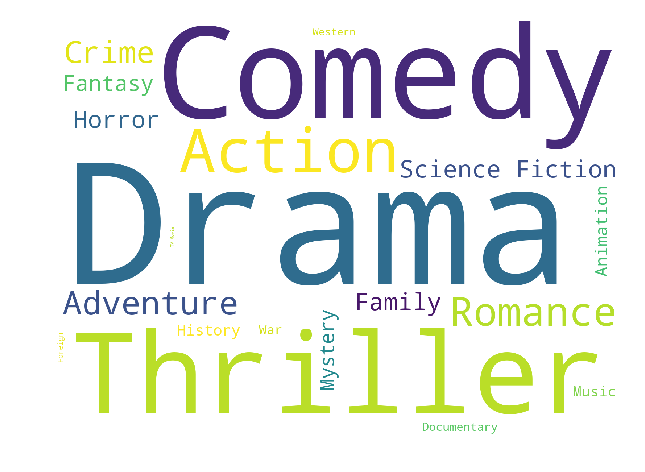

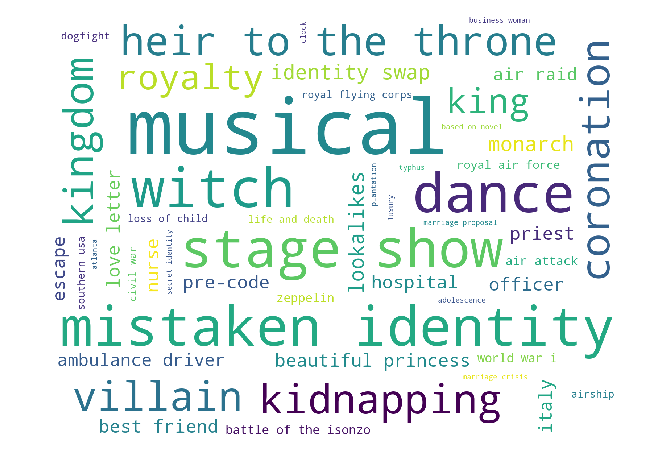

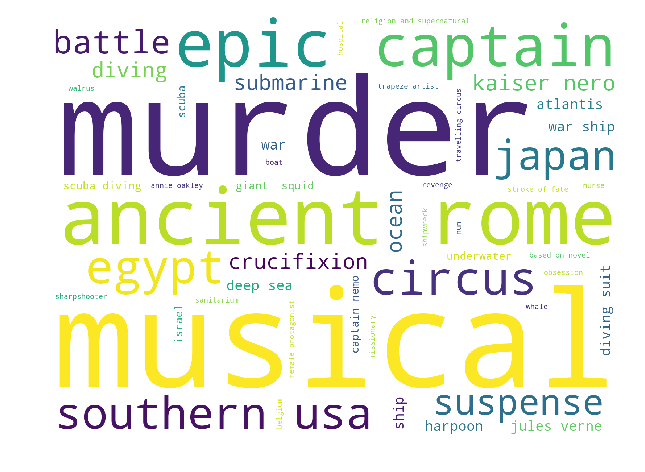

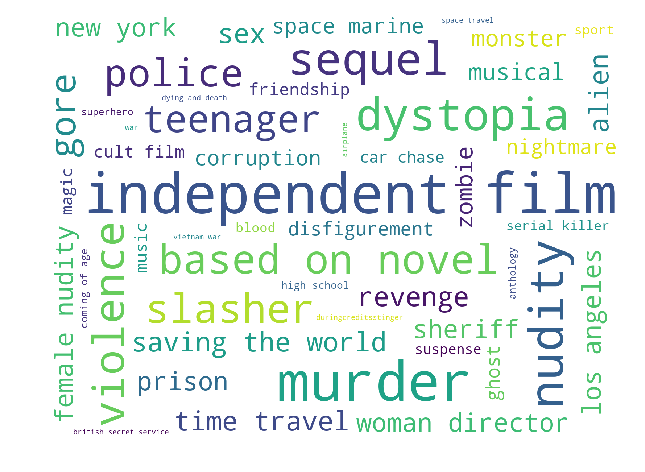

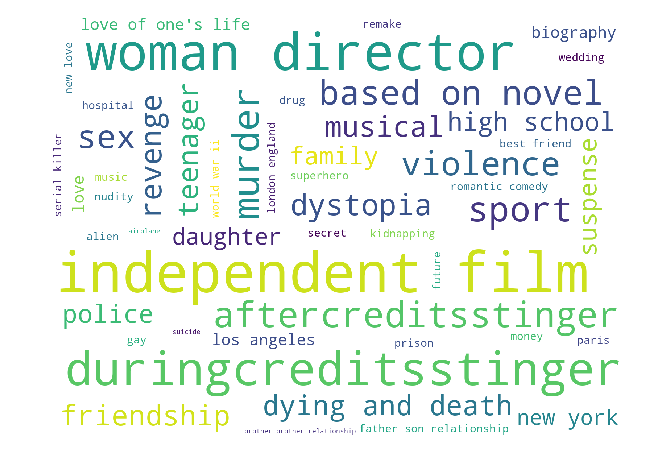

In [6]:
# wordcloud of genres and keywords
def multi_wordcloud(series,filename):
    w=wc.WordCloud(background_color="white",margin=20,width=800,height=600,prefer_horizontal=0.7,max_words=50,scale=2)
    count=multi_count(series,"name")
    w.generate_from_frequencies(count)
    if saving:w.to_file(filename)
    f, ax = plt.subplots(figsize=(16, 8))
    plt.axis('off')
    plt.imshow(w)
    plt.show()

multi_wordcloud(tmdb_5000.genres,filename="wordcloud_genres.png")
multi_wordcloud(tmdb_5000.keywords[tmdb_5000.release_date.apply(lambda x:int(x[:4])//10*10)==1930],filename="wordcloud_keywords_1930.png")
multi_wordcloud(tmdb_5000.keywords[tmdb_5000.release_date.apply(lambda x:int(x[:4])//10*10)==1950],filename="wordcloud_keywords_1950.png")
multi_wordcloud(tmdb_5000.keywords[tmdb_5000.release_date.apply(lambda x:int(x[:4])//10*10)==1980],filename="wordcloud_keywords_1980.png")
multi_wordcloud(tmdb_5000.keywords[tmdb_5000.release_date.apply(lambda x:int(x[:4])//10*10)==2000],filename="wordcloud_keywords_2000.png")

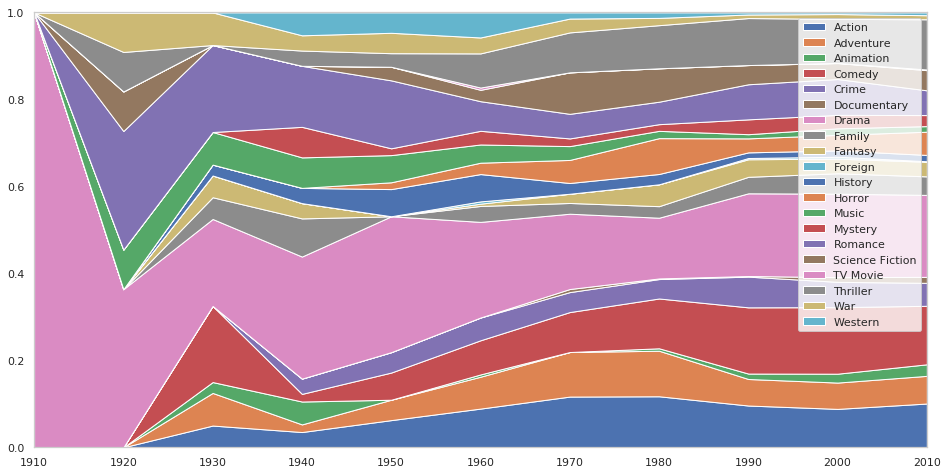

In [7]:
# change of percentage of movies of each genres released in each decade
def multi_stackplot_10year(df,value,filename):
    sns.set(style="whitegrid")
    df=df[["release_date",value]].dropna()
    df.release_date=df.release_date.apply(lambda x:int(x[:4])//10*10)
    df=df.sort_values("release_date")
    years=pd.Series(range(df["release_date"].min(),df["release_date"].max()+1,10),name="year")
    counts=[]
    groups=[]
    for (name,col) in multi_groupby(df,"genres","name"):
        groups.append(name)
        counts.append(pd.merge(years.to_frame(),col.groupby("release_date").size().rename("count").to_frame(),
                               how="left",left_on="year",right_on="release_date").fillna(0).astype(int)["count"])
    counts=np.array(counts)
    counts=counts.transpose(0,1)
    counts=counts/counts.sum(0)
    f, ax = plt.subplots(figsize=(16, 8))
    plt.stackplot(years,counts,labels=groups)
    plt.xticks(years)
    plt.xlim(years.iloc[0],years.iloc[-1])
    plt.ylim(0,1)
    plt.legend()
    if saving:plt.savefig(filename,dpi=200)
    plt.show()

multi_stackplot_10year(tmdb_5000,"genres",filename="stackplot_genres.png")

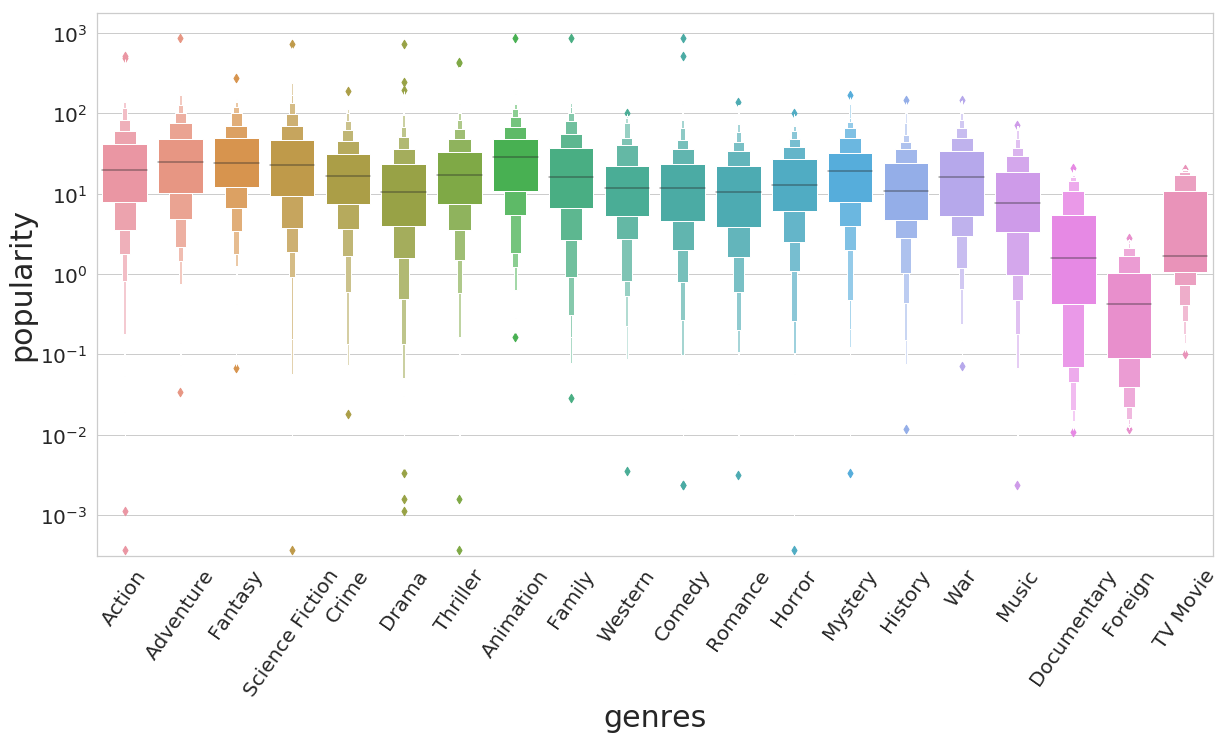

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


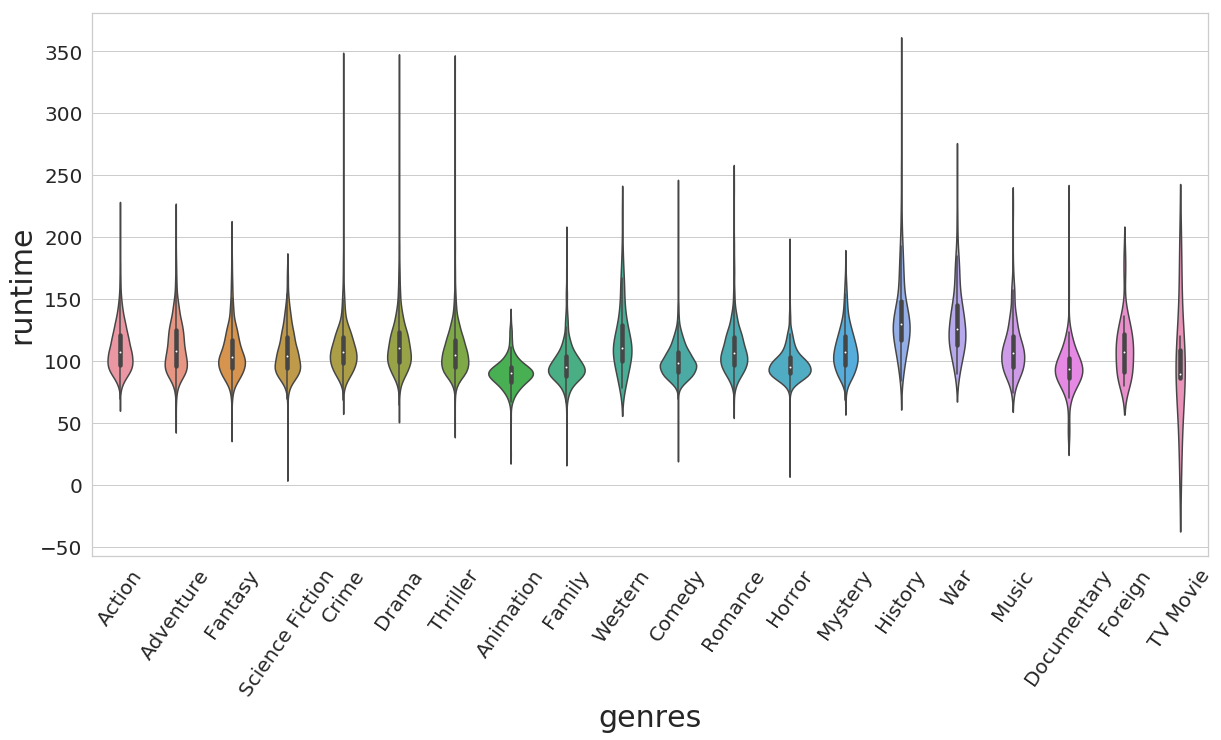

In [8]:
# distribution of popularity and runtime groupby genres
def plotby_box(df,x,y,filename,yscale="linear"):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 10))
    sns.boxenplot(data=expand_multi_feature(df,x,"name"),x=x,y=y)
    plt.yscale(yscale)
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55,fontsize=20)
    plt.xlabel(x,fontsize=30)
    plt.ylabel(y,fontsize=30)
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=150)
    plt.show()
    
def plotby_violin(df,x,y,filename,yscale="linear"):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 10))
    sns.violinplot(data=expand_multi_feature(df,x,"name"),x=x,y=y)
    plt.yscale(yscale)
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55,fontsize=20)
    plt.xlabel(x,fontsize=30)
    plt.ylabel(y,fontsize=30)
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=150)
    plt.show()
    
plotby_box(tmdb_5000,"genres","popularity",yscale="log",filename="genres_popularity.png")
plotby_violin(tmdb_5000,"genres","runtime",yscale="linear",filename="genres_runtime.png")

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


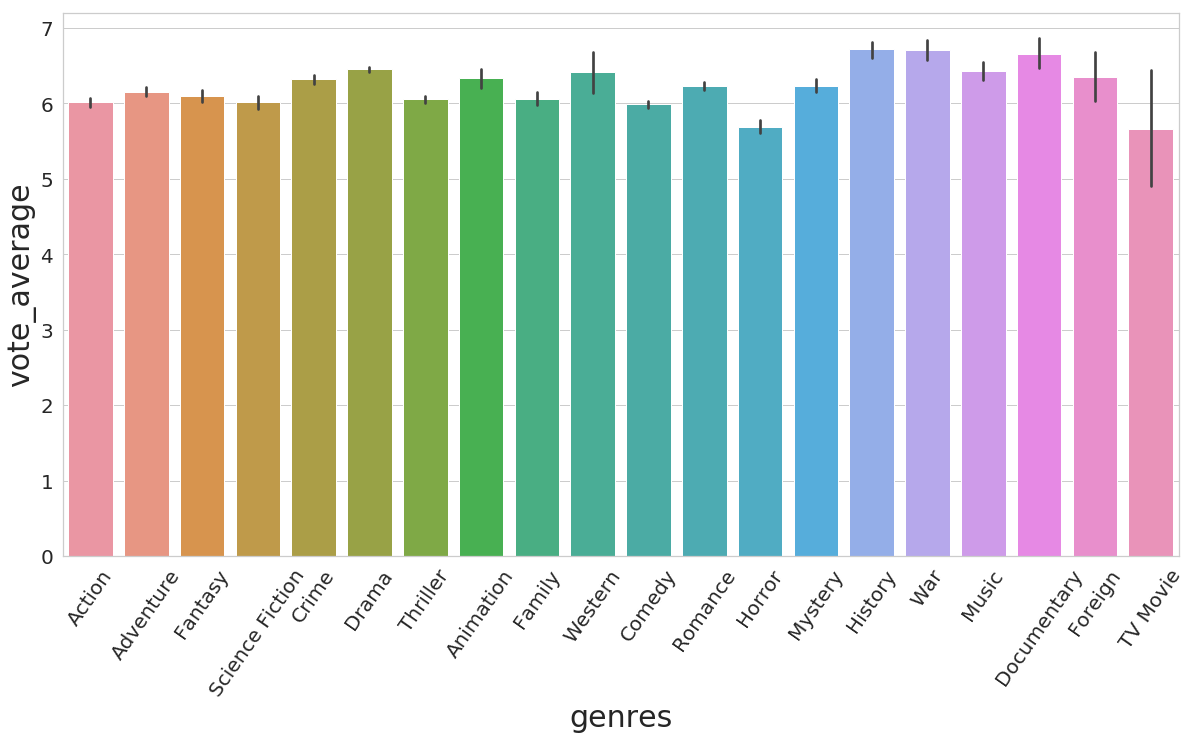

In [9]:
# average vote of each genres' movies
def plotby_bar(df,x,y,filename):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 10))
    sns.barplot(data=expand_multi_feature(df,x,"name"),x=x,y=y)
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55,fontsize=20)
    plt.xlabel(x,fontsize=30)
    plt.ylabel(y,fontsize=30)
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=150)
    plt.show()
    
plotby_bar(tmdb_5000,"genres","vote_average",filename="genres_vote.png")

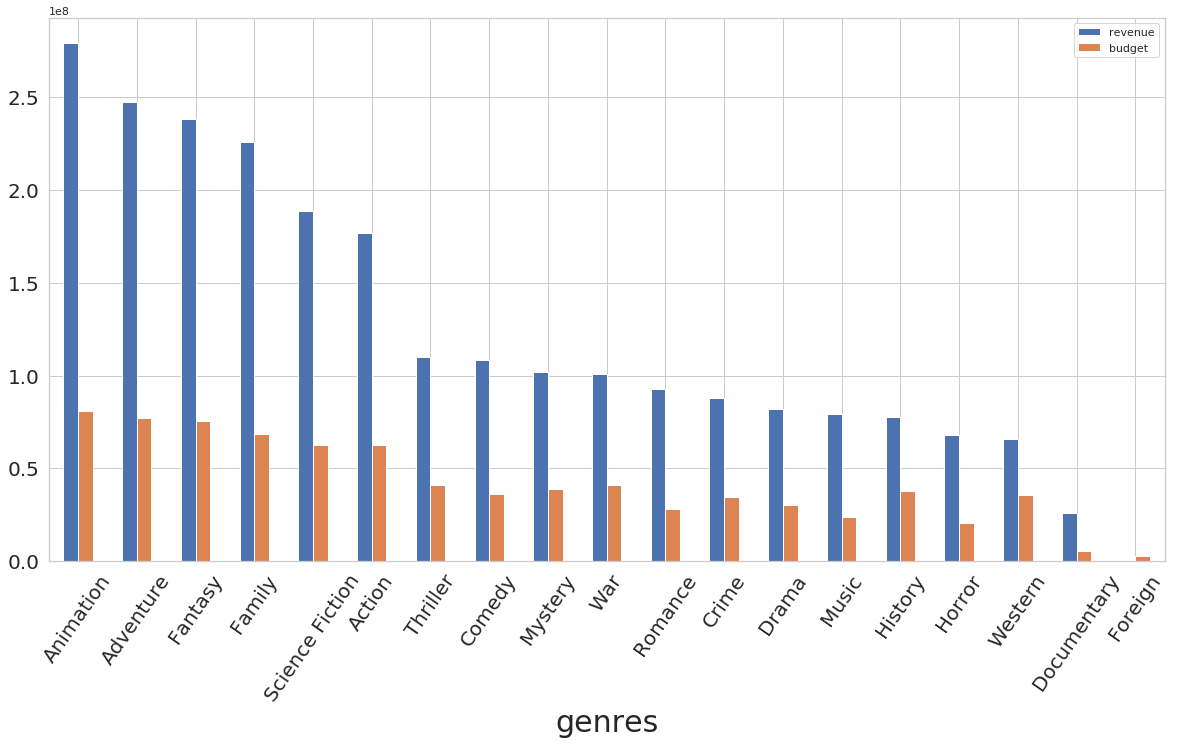

In [10]:
# average budget and revenue of each genres' movies
def plotby_2bar(df,x,y,filename):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 10))
    multi_groupby(df.dropna(subset=y),x,"name")[y].mean().sort_values(y,ascending=False).plot(kind="bar",ax=ax)
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55,fontsize=20)
    plt.xlabel(x,fontsize=30)
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=150)
    plt.show()

plotby_2bar(tmdb_5000,"genres",["revenue","budget"],filename="genres_budget_revenue.png")

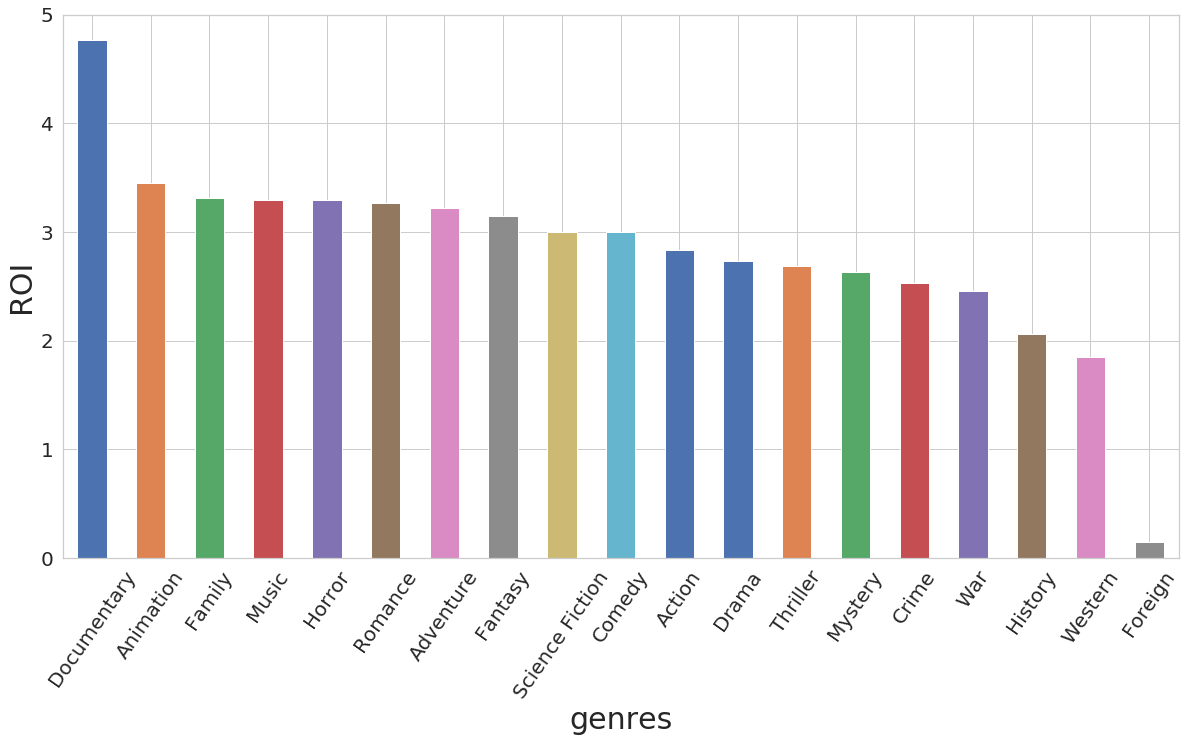

In [11]:
# return on investment of each genres' movies
def plotby_portion(df,x,y,filename):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 10))
#     sns.barplot(data=multi_groupby(df,x,"name")[y].mean().transpose())
    group=multi_groupby(df.dropna(subset=y),x,"name")
    (group[y[0]].mean()/group[y[1]].mean()).sort_values(ascending=False).plot(kind="bar")
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55,fontsize=20)
    plt.xlabel(x,fontsize=30)
    plt.ylabel("ROI",fontsize=30)
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=150)
    plt.show()
    
plotby_portion(tmdb_5000,"genres",["revenue","budget"],filename="genres_ROI.png")

## Recommendation

In [12]:
# define transformers
class SparseMatrixTransformer(BaseEstimator,TransformerMixin):
    def __init__(self,row=None,col=None,value=None,shape=None):
        self.row=row
        self.col=col
        self.value=value
        self.shape=shape
    
    def fit(self,X,y=None):
        self.shape=(X[self.row].max()+1,X[self.col].max()+1)
        return self
    
    def transform(self,X,y=None):
        if type(X) is pd.DataFrame:
            return sparse.csr_matrix(sparse.coo_matrix((X[self.value],(X[self.row],X[self.col])),self.shape))
        else:
            return sparse.csr_matrix(sparse.coo_matrix((X[:,2],(X[:,0],X[:,1])),self.shape))
    
user_movie_transformer=SparseMatrixTransformer(row="userId",col="movieId",value="rating").fit(movielens_rating)
movie_tag_transformer=SparseMatrixTransformer(row="movieId",col="tagId",value="relevance",shape=(user_movie_transformer.shape[1],movielens_tag.tagId.max()+1))

In [13]:
# base class for recommendation system
class RecommenderMixin(BaseEstimator,TransformerMixin):
    def __init__(self,n_rec=10):
        self.n_rec=n_rec
    
    def evaluate(self,X_train,X_valid,silent=False):
        n_users,n_items=X_train.shape
        X=(X_train+X_valid).T
        item_rating=np.array([row.data.mean() if row.nnz else 0 for row in X])
        item_rating[np.isnan(item_rating)]
        mean_rating=X.data.mean()
        if not silent:print("predicting...")
        recommend=self.predict(X_train)
        if not silent:print("evaluating...")
        intersect=np.asarray(X_valid[np.arange(n_users).repeat(self.n_rec),recommend.flatten()].reshape(n_users,-1))
        hit=(intersect!=0).sum()
        precision=hit/recommend.size
        recall=hit/X_valid.nnz
        coverage=np.unique(recommend).size/n_items
        hit_rating=(intersect[intersect!=0]).mean()
        indices=recommend[(intersect!=0)]
        recom_rating=np.average(item_rating[indices])
        print("accuracy=%.4f"%precision)
        print("recall=%.4f"%recall)
        print("cover=%.4f"%coverage)
        print("user's vote to the hit movies=%.4f"%(hit_rating))
        print("average vote to the hit movies=%.4f"%(recom_rating))
        print("average vote to all movies=%.4f"%(mean_rating))
        
    def fit_predict(self,X,y=None):
        return self.fit(X,y).predict(X)

In [14]:
# item based colaborative filtering
# calculating the similarity between movies based on users' vote to the movies
class ItemBasedCF(RecommenderMixin):
    def __init__(self,n_rec=10,n_sim=20,file_name=None,baseline=3.0):
        super().__init__(n_rec=n_rec)
        self.baseline=baseline
        if file_name:
            self.similar_matrix=sparse.load_npz(file_name)
            self.n_sim=self.similar_matrix.shape[1]
        else:
            self.n_sim=n_sim
            self.similar_matrix=None
        
    def save(self,file_name):
        sparse.save_npz(file_name,self.similar_matrix)

    def fit(self,X,y=None,silent=False):
        if not silent:print("calculating the similar matrix...")
        n_users,n_items=X.shape
        user_movie=X.copy()
        user_movie.data-=self.baseline
        norms=sparse.linalg.norm(user_movie,axis=0)
        norms[norms==0]=1
        user_movie*=sparse.diags(1/norms)
        movie_sim_matrix=user_movie.T*user_movie
        if not silent:print("sparsifying similar matrix...")
        row=np.arange(n_items).repeat(self.n_sim)
        col=np.array([np.argpartition(row.toarray().flatten(),-self.n_sim)[-self.n_sim:].copy() for row in movie_sim_matrix]).flatten()
        self.similar_matrix=sparse.csr_matrix(sparse.coo_matrix((np.asarray(movie_sim_matrix[row,col]).flatten(),(row,col)),(n_items,n_items)))
        if not silent:print("fitting done.")
        return self
    
    def transform(self,X,y=None):
        user_movie=X.copy()
        user_movie.data-=self.baseline
        return user_movie*self.similar_matrix
    
    def predict(self,X):
        watched_movies=X.copy()
        watched_movies.data.fill(np.inf)
        movie_favor=self.transform(X)-watched_movies
        return np.array([np.argpartition(row.toarray().flatten(),-self.n_rec)[-self.n_rec:].copy() for row in movie_favor])
    
# itemCF=ItemBasedCF(file_name="ItemBasedCF.npz")

In [15]:
# content based recommendation system
# calculating the similarity between movies based their relevance to each tags
class ContentBasedRS(RecommenderMixin):
    def __init__(self,n_rec=10,n_sim=100,file_name=None,baseline=3.0):
        super().__init__(n_rec=n_rec)
        self.baseline=baseline
        if file_name:
            self.similar_matrix=sparse.load_npz(file_name)
            self.n_sim=self.similar_matrix.shape[1]
        else:
            self.n_sim=n_sim
            self.similar_matrix=None
        
    def save(self,file_name):
        sparse.save_npz(file_name,self.similar_matrix)

    def fit(self,X,y=None,silent=False):
        n_items,n_features=X.shape
        if not silent:print("sparsifying relevance matrix...")
        row=np.arange(n_items).repeat(self.n_sim)
        col=np.array([np.argpartition(row.toarray().flatten(),-self.n_sim)[-self.n_sim:].copy() for row in X]).flatten()
        relevance_matrix=sparse.csr_matrix(sparse.coo_matrix((np.asarray(X[row,col]).flatten(),(row,col)),(n_items,n_features)))
        if not silent:print("calculating the similar matrix...")
        movie_sim_matrix=relevance_matrix*relevance_matrix.T
        if not silent:print("sparsifying similar matrix...")
        row=np.arange(n_items).repeat(self.n_sim)
        col=np.array([np.argpartition(row.toarray().flatten(),-self.n_sim)[-self.n_sim:].copy() for row in movie_sim_matrix]).flatten()
        self.similar_matrix=sparse.csr_matrix(sparse.coo_matrix((np.asarray(movie_sim_matrix[row,col]).flatten(),(row,col)),(n_items,n_items)))
        if not silent:print("fitting done.")
        return self
    
    def transform(self,X,y=None):
        user_movie=X.copy()
        user_movie.data-=self.baseline
        return user_movie*self.similar_matrix
    
    def predict(self,X):
        watched_movies=X.copy()
        watched_movies.data.fill(np.inf)
        movie_favor=self.transform(X)-watched_movies
        return np.array([np.argpartition(row.toarray().flatten(),-self.n_rec)[-self.n_rec:].copy() for row in movie_favor])
    
# contentRS=ContentBasedCF(file_name="ContentBasedRS.npz")

In [16]:
# fitting content based recommendation system
contentRS=ContentBasedRS()
%time contentRS.fit(movie_tag_transformer.transform(movielens_score))
if saving:contentRS.save("ContentBasedRS.npz")

sparsifying relevance matrix...
calculating the similar matrix...
sparsifying similar matrix...
fitting done.
CPU times: user 3min 1s, sys: 4.46 s, total: 3min 6s
Wall time: 3min 6s


In [17]:
# fitting item based colaborative filtering
itemCF=ItemBasedCF()
%time itemCF.fit(user_movie_transformer.transform(movielens_rating))
if saving:itemCF.save("ItemBasedCF.npz")

calculating the similar matrix...
sparsifying similar matrix...
fitting done.
CPU times: user 1min 25s, sys: 14.6 s, total: 1min 40s
Wall time: 1min 40s


In [18]:
# example of the most similar movies to a specified movie
def movie_similar(rs,movie):
    index=rs.similar_matrix[movie].indices
    return pd.merge(movielens_movie.iloc[index].reset_index(drop=True),pd.DataFrame({"similar":rs.similar_matrix[movie,index].toarray().flatten()}),left_index=True,right_index=True).sort_values("similar",ascending=False).reset_index(drop=True)
    
movie_similar(itemCF,17506)

,movieId,title,genres,similar
0,88140,Captain America: The First Avenger (2011),Action|Adventure|Sci-Fi|Thriller|War,1.000000
1,86332,Thor (2011),Action|Adventure|Drama|Fantasy|IMAX,0.482128
2,89745,"Avengers, The (2012)",Action|Adventure|Sci-Fi|IMAX,0.413647
3,77561,Iron Man 2 (2010),Action|Adventure|Sci-Fi|Thriller|IMAX,0.401208
4,87232,X-Men: First Class (2011),Action|Adventure|Sci-Fi|Thriller|War,0.390539
5,102125,Iron Man 3 (2013),Action|Sci-Fi|Thriller|IMAX,0.354732
6,95510,"Amazing Spider-Man, The (2012)",Action|Adventure|Sci-Fi|IMAX,0.331462
7,91542,Sherlock Holmes: A Game of Shadows (2011),Action|Adventure|Comedy|Crime|Mystery|Thriller,0.323050
8,110102,Captain America: The Winter Soldier (2014),Action|Adventure|Sci-Fi|IMAX,0.321387
9,106072,Thor: The Dark World (2013),Action|Adventure|Fantasy|IMAX,0.298413


In [19]:
# example of movies recommended to a specified movie
def user_recommend(rs,user):
    return movielens_movie.iloc[rs.predict(user_movie_transformer.transform(movielens_rating)[[user]]).flatten()].reset_index(drop=True)
    
user_recommend(itemCF,5)

,movieId,title,genres
0,318,"Shawshank Redemption, The (1994)",Crime|Drama
1,440,Dave (1993),Comedy|Romance
2,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
3,539,Sleepless in Seattle (1993),Comedy|Drama|Romance
4,805,"Time to Kill, A (1996)",Drama|Thriller
5,150,Apollo 13 (1995),Adventure|Drama|IMAX
6,356,Forrest Gump (1994),Comedy|Drama|Romance|War
7,36,Dead Man Walking (1995),Crime|Drama
8,457,"Fugitive, The (1993)",Thriller
9,11,"American President, The (1995)",Comedy|Drama|Romance


In [20]:
# see the already watched movies of a specified movie
def user_watched(user):
    watched_movies=movielens_rating[movielens_rating.userId==user]
    return pd.DataFrame({"title":movielens_movie.title.iloc[watched_movies.movieId],"genres":movielens_movie.genres.iloc[watched_movies.movieId],"rating":watched_movies.rating.values})

user_watched(5)

,title,genres,rating
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0
2,Grumpier Old Men (1995),Comedy|Romance,3.0
6,Sabrina (1995),Comedy|Romance,5.0
16,Sense and Sensibility (1995),Drama|Romance,5.0
51,Mighty Aphrodite (1995),Comedy|Drama|Romance,5.0
61,Mr. Holland's Opus (1995),Drama,5.0
133,Down Periscope (1996),Comedy,3.0
138,Up Close and Personal (1996),Drama|Romance,4.0
139,"Birdcage, The (1996)",Comedy,5.0
257,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.0


In [21]:
# evaluating and comparing the recommendation system
rating_train,rating_valid=train_test_split(movielens_rating[["userId","movieId","rating"]])
rating_train=user_movie_transformer.transform(rating_train)
rating_valid=user_movie_transformer.transform(rating_valid)
%time ItemBasedCF().fit(rating_train).evaluate(rating_train,rating_valid)
%time ContentBasedRS().fit(movie_tag_transformer.transform(movielens_score)).evaluate(rating_train,rating_valid)

calculating the similar matrix...
sparsifying similar matrix...
fitting done.
predicting...
evaluating...
accuracy=0.2706
recall=0.0749
cover=0.1889
user's vote to the hit movies=4.2957
average vote to the hit movies=4.0459
average vote to all movies=3.5255
CPU times: user 1min 35s, sys: 6.56 s, total: 1min 42s
Wall time: 1min 42s
sparsifying relevance matrix...
calculating the similar matrix...
sparsifying similar matrix...
fitting done.
predicting...
evaluating...
accuracy=0.1242
recall=0.0344
cover=0.1465
user's vote to the hit movies=4.3634
average vote to the hit movies=4.0527
average vote to all movies=3.5255
CPU times: user 4min 1s, sys: 8.22 s, total: 4min 9s
Wall time: 4min 9s


## Prediction

Let's predict the average vote of the movies.

In [22]:
data=tmdb_5000.dropna(subset=["vote_count"]).copy()
data["release_year"]=data.release_date.apply(lambda x:int(x[:4]))
data=data[data.vote_count>=100].copy()

In [23]:
# check multi-hot features
pd.DataFrame({
    "cast":pd.Series(multi_count(tmdb_5000.cast)).describe(),
    "crew":pd.Series(multi_count(tmdb_5000.crew)).describe(),
    "companies":pd.Series(multi_count(tmdb_5000.production_companies)).describe(),
    "countries":pd.Series(multi_count(tmdb_5000.production_countries,index="iso_3166_1")).describe(),
    "languages":pd.Series(multi_count(tmdb_5000.spoken_languages,index="iso_639_1")).describe(),
    "keywords":pd.Series(multi_count(tmdb_5000.keywords)).describe(),
    "genres":pd.Series(multi_count(tmdb_5000.genres)).describe(),
}).round(2).astype(object)

,cast,crew,companies,countries,languages,keywords,genres
count,54588,52885,5047,88,87,9813,20
mean,1.95,2.45,2.71,73.14,79.74,3.69,608
std,2.83,3.49,10.61,427.41,483.02,9.67,606.93
min,1,1,1,1,1,1,8
25%,1,1,1,1,1,1,174.75
50%,1,1,1,3,4,1,468.5
75%,2,2,2,18.25,17.5,3,816
max,67,104,319,3956,4485,324,2297


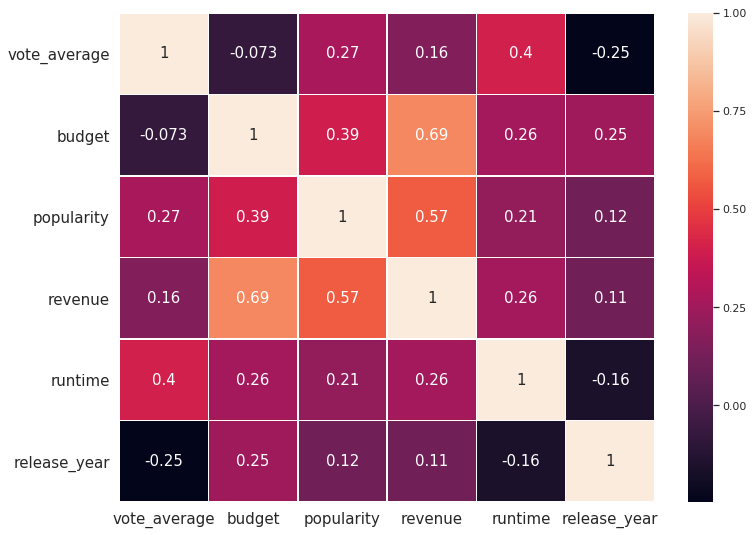

In [24]:
# correlation between numeric features
def plot_corr(df,filename):
    plt.subplots(figsize=(12, 9))
    sns.heatmap(df.corr(),annot=True,linewidths=.5,annot_kws={"fontsize":15})
    plt.yticks(rotation=0,fontsize=15)
    plt.xticks(rotation=0,fontsize=15)
    if saving:plt.savefig(filename,dpi=150)
    plt.show()

plot_corr(data[["vote_average","budget","popularity","revenue","runtime","release_year"]],filename="corr.png")

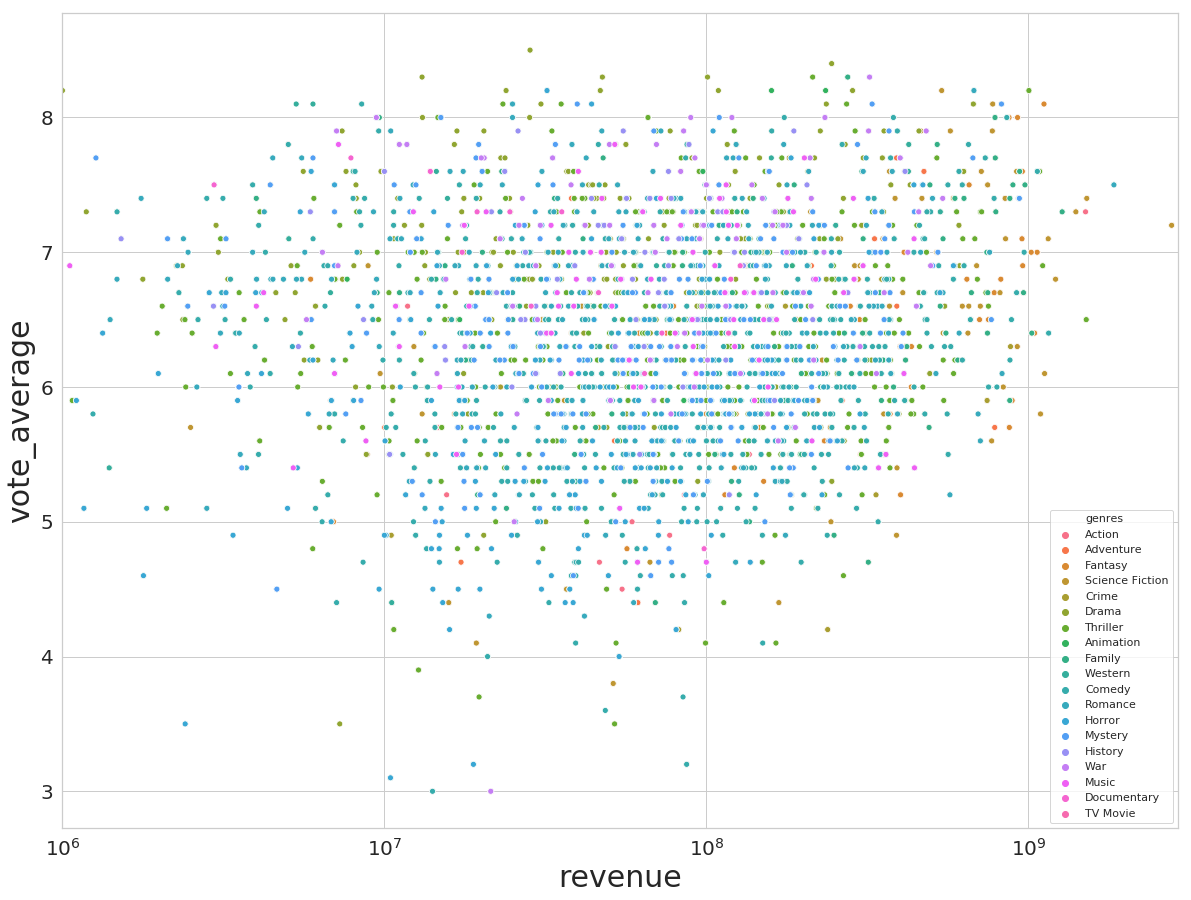

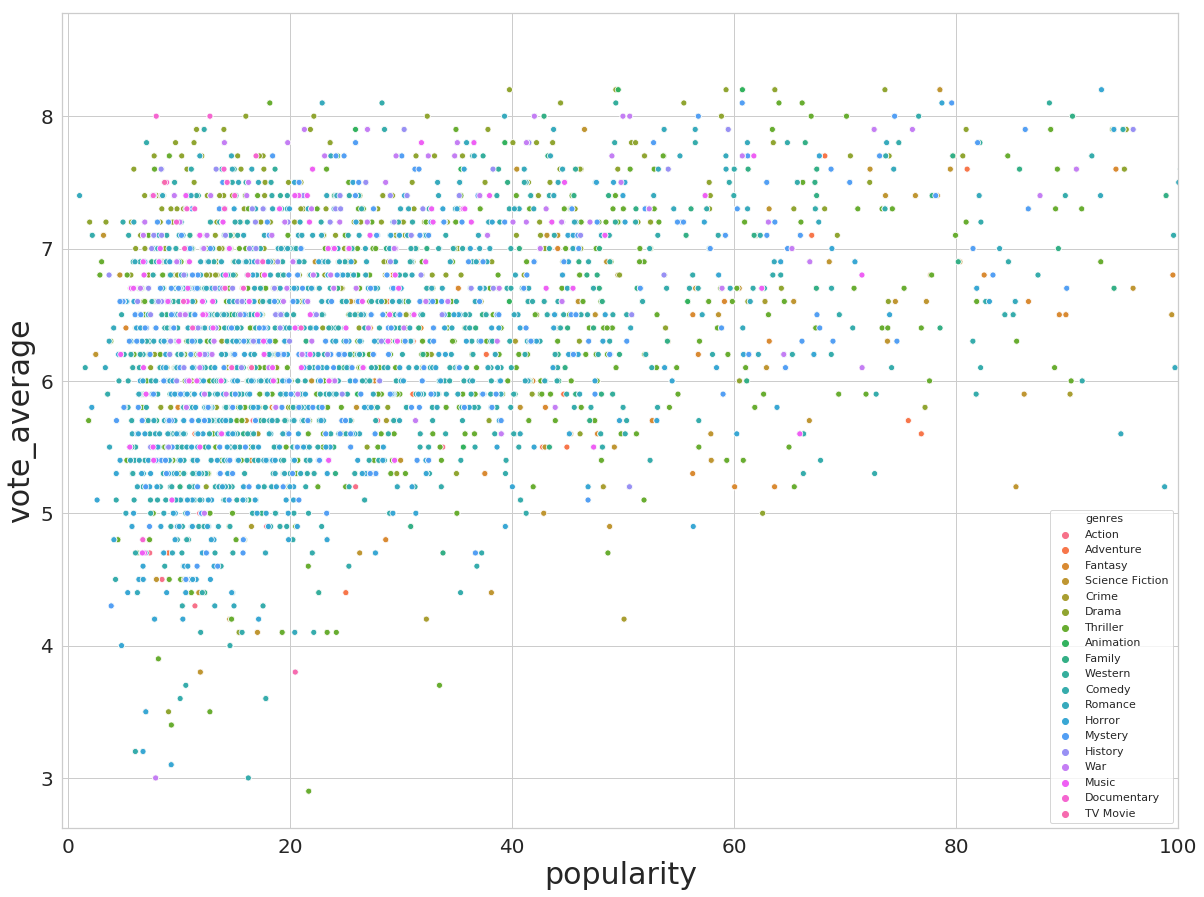

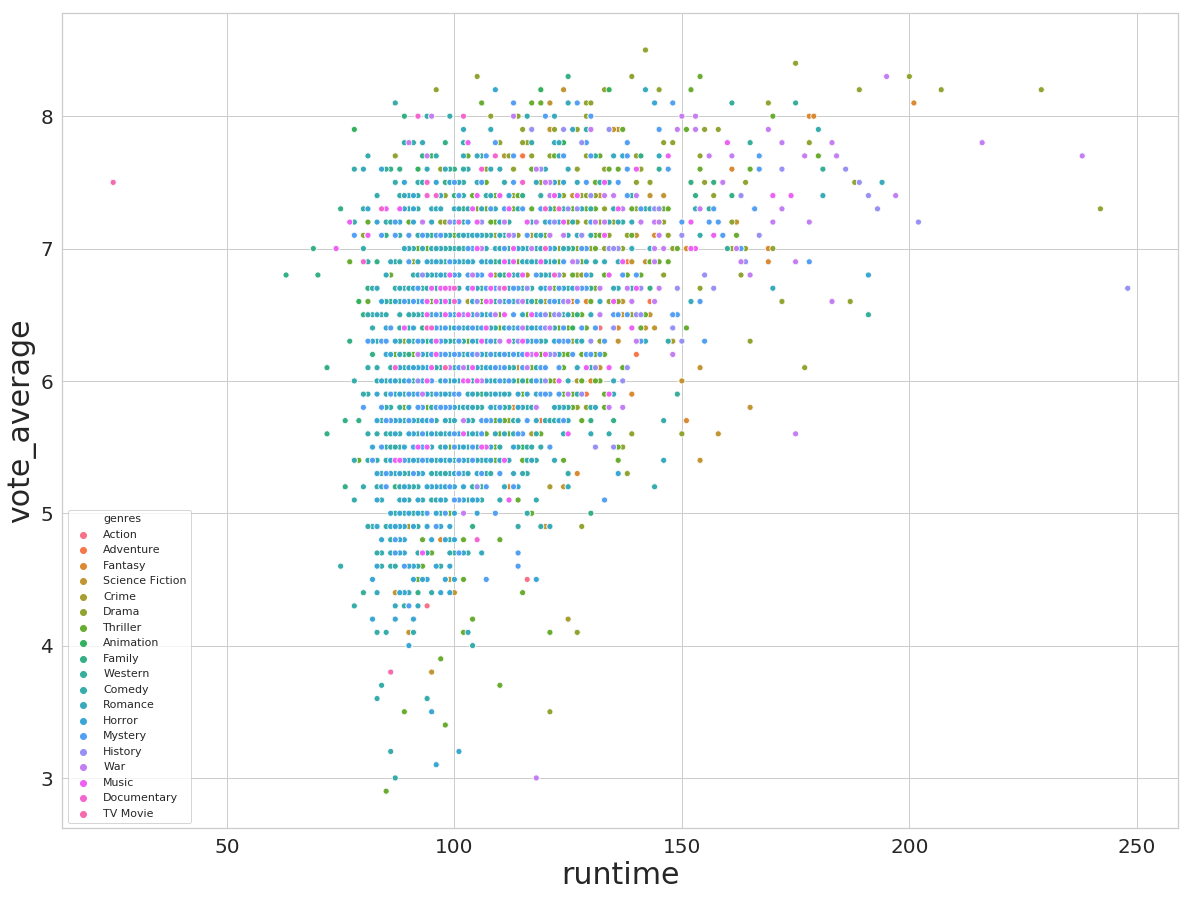

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


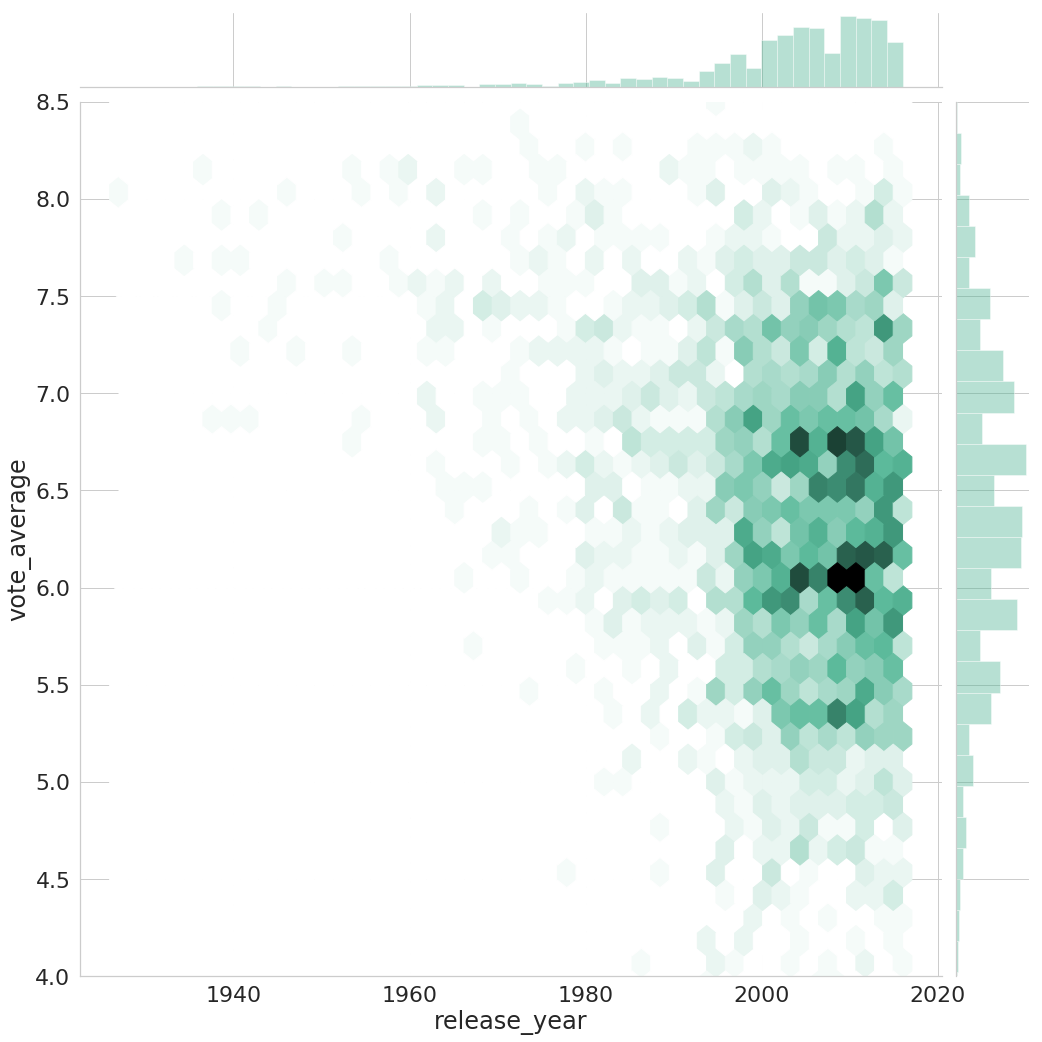

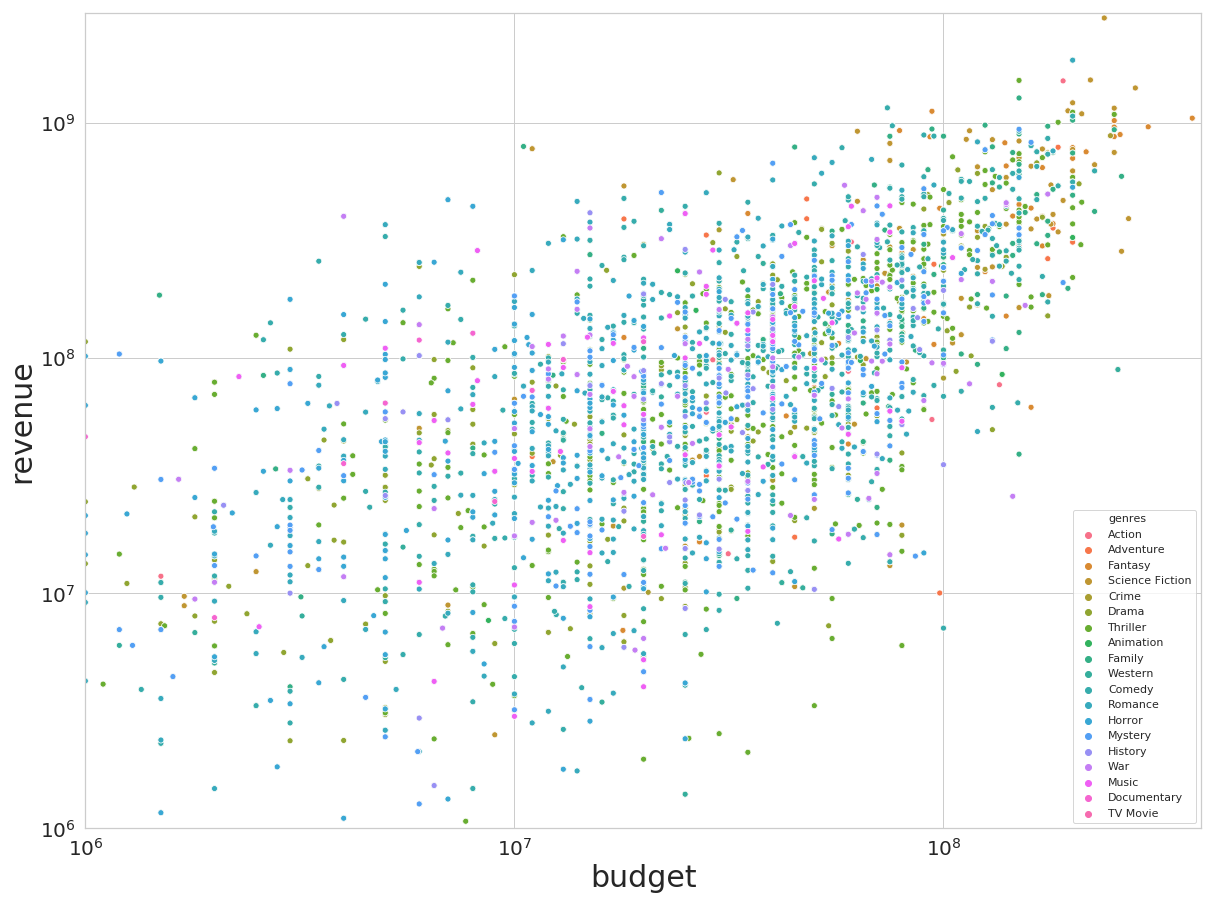

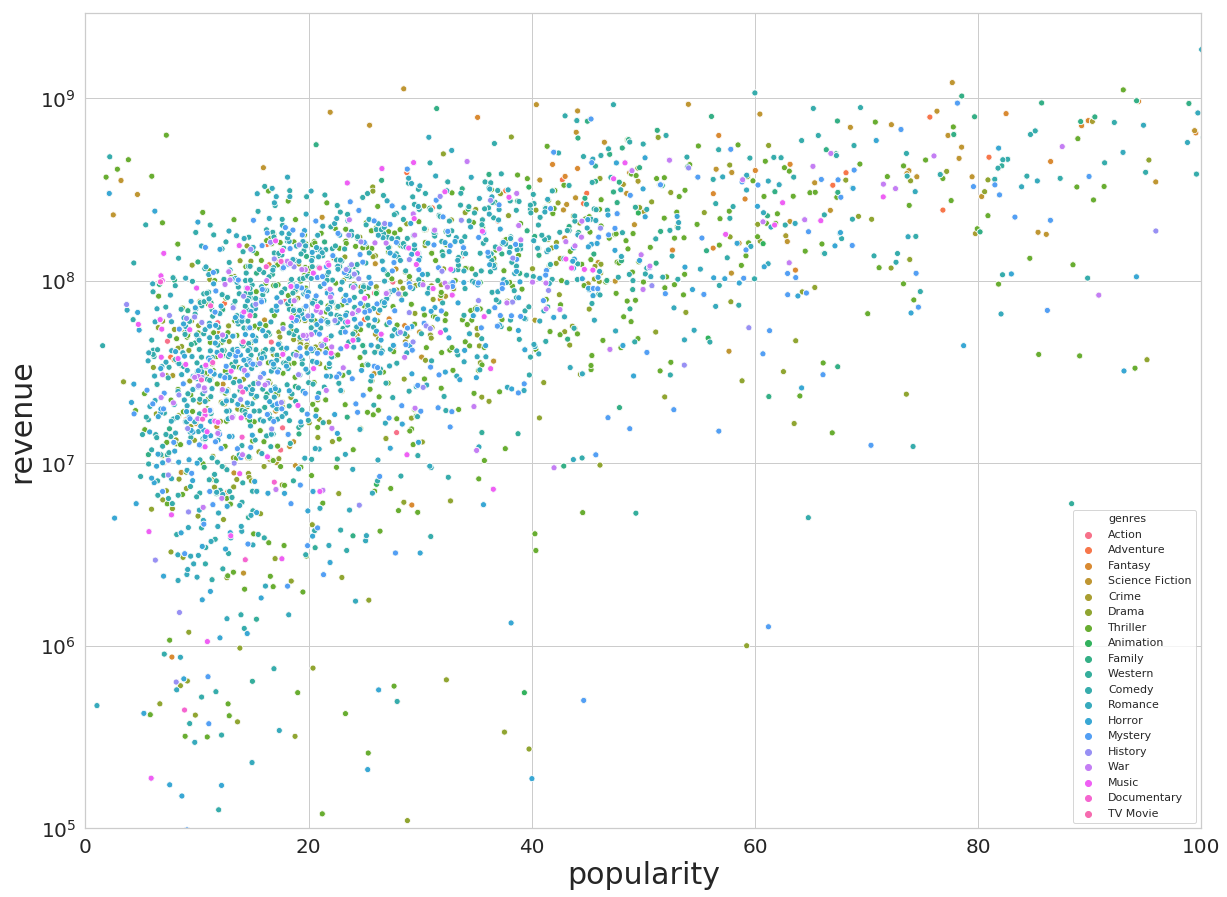

In [25]:
# see the scatter of features
def plotscatter(df,x,y,hue,filename,xlim=None,ylim=None,xscale=None,yscale=None):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 15))
    sns.scatterplot(data=expand_multi_feature(df,hue,"name"),x=x,y=y,hue=hue)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.xlabel(x,fontsize=30)
    plt.ylabel(y,fontsize=30)
    if xlim:plt.xlim(xlim)
    if xscale:plt.xscale(xscale)
    if ylim:plt.ylim(ylim)
    if yscale:plt.yscale(yscale)
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=150)
    plt.show()

def plotjoint(df,x,y,filename,xlim=None,ylim=None,xscale=None,yscale=None):
    sns.set(style=None,font_scale=2)
    grid=sns.jointplot(data[x],data[y],kind="hex",color="#4CB391",height=15,ratio=10,xlim=xlim,ylim=ylim)
    if saving:grid.savefig(filename)
        
    
plotscatter(data,"revenue","vote_average","genres",xlim=1e6,xscale="log",filename="scatter_revenue_vote.png")
plotscatter(data,"popularity","vote_average","genres",xlim=(-0.5,100),filename="scatter_popularity_vote.png")
plotscatter(data,"runtime","vote_average","genres",filename="scatter_runtime_vote.png")
plotjoint(data,"release_year","vote_average",filename="scatter_year_vote.png",ylim=(4,8.5))

plotscatter(data,"budget","revenue","genres",xlim=1e6,ylim=1e6,xscale="log",yscale="log",filename="scatter_budget_revenue.png")
plotscatter(data,"popularity","revenue","genres",xlim=(0,100),ylim=1e5,yscale="log",filename="scatter_popularity_revenue.png")

In [26]:
# selected features
label_name="vote_average"
numeric_features=["budget","runtime","popularity","revenue","release_year"]
multi_hot_features=["genres"]

In [27]:
# define transformers
class MultiHotEncoder(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.categories=[]
    
    def fit(self,X,y=None):
        self.categories=[]
        for name,series in X.iteritems():
            df=to_split(series).str.get_dummies()
            df.columns=name+"_"+df.columns
            self.categories+=list(df.columns)
        return self
    
    def transform(self,X,y=None):
        result=pd.DataFrame(index=X.index)
        for name,series in X.iteritems():
            df=to_split(series).str.get_dummies()
            df.columns=name+"_"+df.columns
            result=result.join(df)
        for i,cate in enumerate(self.categories):
            if result.columns[i]!=cate:
                result.insert(i,cate,0)
        return result.reset_index(drop=True)

    
def to_split(series,sep="|",index="name",threshold=0):
    count=multi_count(series,index)
    result=pd.Series(index=series.index)
    for i in range(series.size):
        l=eval(series.iloc[i])
        result.iloc[i]=""
        for x in l:
            if count[x[index]]>=threshold:
                result.iloc[i]+=x[index]+sep
    return result

class DataFrameTransformer(BaseEstimator,TransformerMixin):
    def __init__(self,transformers):
        self.transformers=transformers
        
    def fit(self,X,y=None):
        for i in self.transformers:
            if i[1]!="passthrough" and i[1]!="drop":i[1].fit(X[i[2]])
        return self
    
    def transform(self,X,y=None):
        result=pd.DataFrame(index=range(X.shape[0]))
        for i in self.transformers:
            if i[1]=="passthrough":x=X[i[2]].reset_index(drop=True)
            elif i[1]=="drop":continue
            else:x=i[1].transform(X[i[2]])
            if type(x) is not pd.DataFrame:x=pd.DataFrame(x,columns=i[2])
            result=result.join(x)
        return result

In [28]:
preprocessor=DataFrameTransformer([
    ("numeric","passthrough",numeric_features),
])
xgb_params={"silent":True,"eta":0.01,'subsample': 0.8,'colsample_bytree': 0.8,"max_depth":5}
dmat=xgb.DMatrix(preprocessor.fit_transform(data),data[label_name])
xgb.cv(xgb_params,dmat,num_boost_round=20000,early_stopping_rounds=500,nfold=4,seed=42,feval=lambda preds,dmat:("R2score",sklearn.metrics.r2_score(dmat.get_label(),preds))).iloc[[-1]]

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,train-R2score-mean,train-R2score-std,train-rmse-mean,train-rmse-std,test-R2score-mean,test-R2score-std,test-rmse-mean,test-rmse-std
752,0.686275,0.009423,0.467343,0.005496,0.466709,0.033595,0.608674,0.012726


In [29]:
preprocessor=DataFrameTransformer([
    ("numeric","passthrough",numeric_features),
    ("multihot",MultiHotEncoder(),multi_hot_features),
])

In [30]:
xgb_params={"silent":True,"eta":0.01,'subsample': 0.8,'colsample_bytree': 0.7,"max_depth":7}
dmat=xgb.DMatrix(preprocessor.fit_transform(data),data[label_name])
result=xgb.cv(xgb_params,dmat,num_boost_round=20000,early_stopping_rounds=500,nfold=4,seed=42,feval=lambda preds,dmat:("R2score",sklearn.metrics.r2_score(dmat.get_label(),preds)))
result.iloc[[-1]]

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,train-R2score-mean,train-R2score-std,train-rmse-mean,train-rmse-std,test-R2score-mean,test-R2score-std,test-rmse-mean,test-rmse-std
815,0.880091,0.002856,0.288941,0.002273,0.579301,0.020804,0.540731,0.006675


In [31]:
X=preprocessor.fit_transform(data)
y=data[label_name]
train_X,valid_X,train_y,valid_y=train_test_split(X,y)
train_mat=xgb.DMatrix(train_X,train_y)
valid_mat=xgb.DMatrix(valid_X,valid_y)
model=xgb.train(xgb_params,train_mat,num_boost_round=result.shape[0])

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


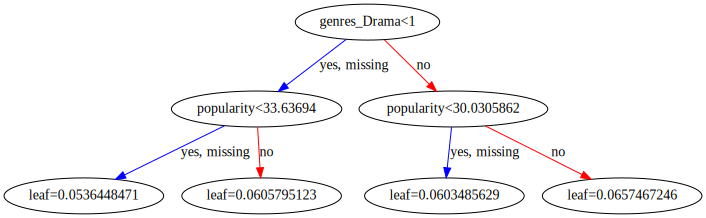

In [32]:
xgb.to_graphviz(model)

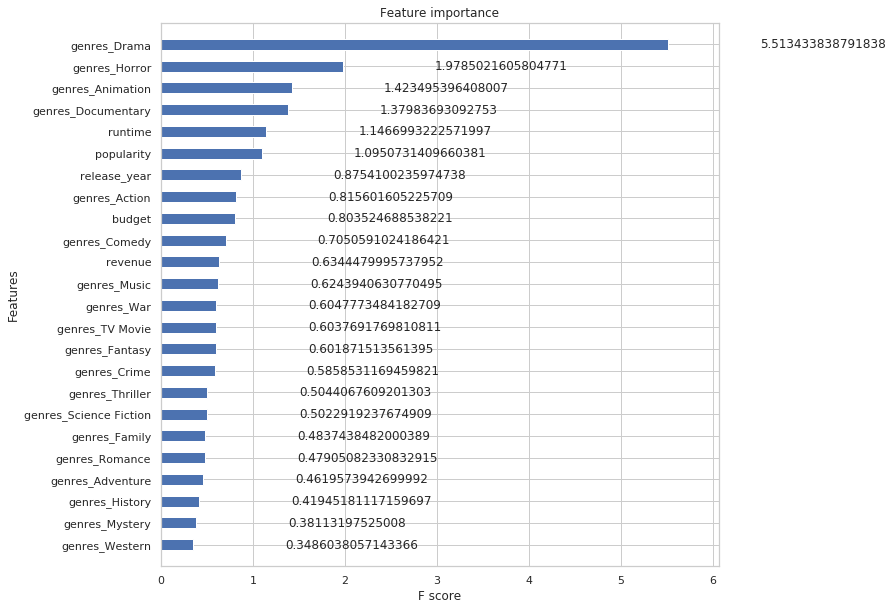

In [33]:
def plot_importance(model,filename,importance_type="weight"):
    f,ax=plt.subplots(figsize=(10,10))
    xgb.plot_importance(model,height=0.5,ax=ax,importance_type=importance_type)
    if saving:plt.savefig(filename,dpi=150,bbox_inches="tight")
    plt.show()
    
plot_importance(model,importance_type="gain",filename="boost_tree_importance.png")